### 0.0 Load libraries

In [129]:
import os
import squarify    # pip install squarify (algorithm for treemap)
import numpy as np
from data_loader import download_url
from preprocessing import z_score_outlier_detection, data_replacement, corr_filter, split_data, standardize, split_groups
from IPython.core.interactiveshell import InteractiveShell
from utils import calculate_mse, calculate_mse_loss, cross_validation_iter, build_k_indices 
from proj1_helpers import load_csv_data, predict_labels, create_csv_submission
from implementations import *

# For visualisation purposes
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from visualization import corr_dot

# Global seed for reproducibility
np.random.seed(0)

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
InteractiveShell.ast_node_interactivity = "last_expr"

### 0.1 Load the data

In [86]:
Y_tr, X_tr, ids_tr = load_csv_data(config.TRAIN_DATA_CSV_PATH)
Y_te, X_te, ids_te = load_csv_data(config.TEST_DATA_CSV_PATH)

In [14]:
# Use pandas to take a glimpse at the data
col = ["feat{}".format(indx+1) for indx in range(30)]
X_df = pd.DataFrame(X, columns=col)
X_te_df = pd.DataFrame(X_te, columns=col)
Y_df = pd.DataFrame(Y)
display(X_df.head(), Y_df.head())

,feat1,feat2,feat3,feat4,feat5,feat6,feat7,feat8,feat9,feat10,...,feat21,feat22,feat23,feat24,feat25,feat26,feat27,feat28,feat29,feat30
0,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,197.760,...,-0.277,258.733,2.0,67.435,2.150,0.444,46.062,1.24,-2.475,113.497
1,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,125.157,...,-1.916,164.546,1.0,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226
2,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,197.814,...,-2.186,260.414,1.0,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251
3,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,75.968,...,0.060,86.062,0.0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000
4,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,57.983,...,-0.871,53.131,0.0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000


,0
0,1.0
1,-1.0
2,-1.0
3,-1.0
4,-1.0


## 1. Exploratory data analysis

### 1.1 Inspect the missing values

In [60]:
# Check for each feature, how many -999 (missing values) it has
missing_percentage = []
for indx, col in enumerate(X_df.columns):
    print("========================================================")
    missing_percentage.append(100*sum(X_df[col]==-999.)/len(X_df))
    print("Feature {}: Has {} missing values ==> {}%!".format(indx+1, sum(X_df[col]==-999.), missing_percentage[indx]))
    print("Mean {} and Variance {}".format(np.mean(X_df[col]), np.var(X_df[col])))
    print("Number of unique Elements: {}".format(len(np.unique(X_df[col]))))
    print(np.unique(X_df[col]))

Feature 1: Has 38114 missing values ==> 15.2456%!
Mean -49.023079440000004 and Variance 165116.12412717938
Number of unique Elements: 108338
[-999.       9.044    9.222 ...  987.561  988.199 1192.026]
Feature 2: Has 0 missing values ==> 0.0%!
Mean 49.239819276 and Variance 1249.2559418725507
Number of unique Elements: 101637
[0.00000e+00 1.00000e-03 2.00000e-03 ... 5.94287e+02 5.95819e+02
 6.90075e+02]
Feature 3: Has 0 missing values ==> 0.0%!
Mean 81.181981612 and Variance 1666.975302663858
Number of unique Elements: 100558
[   6.329    6.462    7.12  ... 1153.166 1329.913 1349.351]
Feature 4: Has 0 missing values ==> 0.0%!
Mean 57.895961656 and Variance 4052.0295941117856
Number of unique Elements: 115563
[0.000000e+00 5.000000e-03 1.100000e-02 ... 7.628060e+02 1.053807e+03
 2.834999e+03]
Feature 5: Has 177457 missing values ==> 70.9828%!
Mean -708.4206753999999 and Variance 206551.75785299003
Number of unique Elements: 7087
[-9.990e+02  0.000e+00  1.000e-03 ...  8.326e+00  8.459e+00

#### 1.1.1 Insights
The following features containg missing values:
* feat1:  15%
* feat5:  71%
* feat6:  71%
* feat7:  71%
* feat13: 71%
* feat24: 40%
* feat25: 40%
* feat26: 40%
* feat27: 71%
* feat28: 71%
* feat29: 71%
    
Also:
* feat23 has takes only 4 values

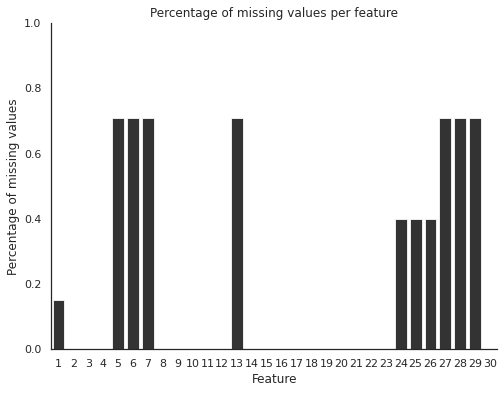

In [234]:
missing_percentage_plot = [x / 100 for x in missing_percentage]
plt.figure(figsize = (8,6))
sns.barplot(x = np.arange(1, len(missing_percentage_plot)+1), y = missing_percentage_plot, color = 'black', alpha = 0.8)
plt.xlabel('Feature')
plt.ylabel('Percentage of missing values')
plt.title('Percentage of missing values per feature')
sns.set(font_scale=1, style='white')
sns.despine();
plt.ylim((0,1));



### 1.2 Further investigate the missing values

In [19]:
missing_values = []
missing_values_unique = []
for indc in range(len(X_df)):
    missing_values.append([x == -999. for x in list(X_df.iloc[indc])])
    
for m in missing_values:
    if not (m in missing_values_unique):
        missing_values_unique.append([i for i, x in enumerate(m) if x])
        
np.unique(missing_values_unique)

/home/mogan/anaconda3/envs/ada/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


array([list([]), list([0]),
       list([0, 4, 5, 6, 12, 23, 24, 25, 26, 27, 28]),
       list([0, 4, 5, 6, 12, 26, 27, 28]),
       list([4, 5, 6, 12, 23, 24, 25, 26, 27, 28]),
       list([4, 5, 6, 12, 26, 27, 28])], dtype=object)

#### 1.2.1 Insights

We basically have 6 groups of data in respect to missing values
* Group 1: Have no missing values
* Group 2: Missing features: [1]
* Group 4: Missing features: [5,6,7,13,27,28,29]
* Group 5: Missing features: [1,5,6,7,13,27,28,29]
* Group 6: Missing features: [5,6,7,13,24,25,26,27,28,29] 
* Group 7: Missing features: [1,5,6,7,13,24,25,26,27,28,29] 

In [87]:
# Split data in the six groups and plot amount of data for each category
groups_tr_Y, groups_tr_X, indc_list_tr = split_groups(Y_tr, X_tr)
groups_te_Y, groups_te_X, indc_list_te = split_groups(Y_te, X_te)

In [124]:
group_size = []
for i in range(6):
    group_size.append(groups_tr_X[i].shape[0])
group_size_prop = [x/np.sum(group_size) for x in group_size]
group_size_prop

[0.272456, 0.017716, 0.279928, 0.030248, 0.29516, 0.104492]

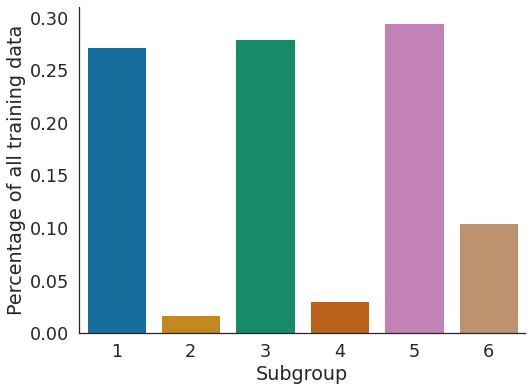

In [229]:
plt.figure(figsize = (8,6))
subgroups_plot = sns.barplot(y = group_size_prop, x = np.arange(1,7), palette= 'colorblind')
plt.xlabel('Subgroup')
plt.ylabel('Percentage of all training data')
#plt.title('Percentage of training data in each subgroup')
sns.set(font_scale=1.6, style='white')
sns.despine();
subgroups_plot.figure.savefig("subgroups.png")

## 2. Preprocessing

In [210]:
X_tr = standardize(X_tr)
X_te = standardize(X_te)

In [211]:
# Find correlated features, delete from datasets
X_tr , _ = corr_filter(X_tr, 0.93)

# Get a random subset of the data for plotting
N = 50
X_sub = X_tr[np.random.permutation(X.shape[0])][:N,:]


In [212]:
# Function for displaying correlation dots in the paired plot
def corr_dot(*args, **kwargs):
    """
    Calculate the correlation of features and display it:
    positive correlation displayed with red colours,
    negative correlation with blue colours.
    The greater the absolute value of the correlation, 
    the greater the size of the corresponding number.
    """
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 10000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5, ], xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)


In [ ]:
# Paired plot of features
sns.set(style='white', font_scale=1)
g = sns.PairGrid(pd.DataFrame(X_sub), aspect=1.4, diag_sharey=False)
g.map_lower(sns.regplot, scatter_kws={'s':10})
g.map_diag(sns.distplot, kde_kws={'color': 'black'})
g.map_upper(corr_dot);

g.savefig("paired_feature_plot.png")